# CTR Prediction Solution

* [Avazu CTR Prediction](https://www.kaggle.com/c/avazu-ctr-prediction) dataset from 2014 Kaggle competition
* 11 days of anonymized bidrequests, 24 columns - timestamp, click, slot properties, device properties, C?? attributes
* we are going to use a subset 500.000 requests (pre-cached for our exact queries - otherwise needs credentials)
* this is only a couple of hours of data - not even a full day (model wont be bale to properly capture temporal features)
* not doing datascience (no HPT)
* using [Openschema catalog](https://openschema.readthedocs.io/en/latest/_auto/_auto/openschema.kaggle.Avazu.html)


## Project Setup

Let's start by setting up the project skeleton and the main components.

### Starting New Project

We are going to initialize new ForML project with the following parameters:

* project name will be `forml-solution-avazuctr`
* but we want the python package to be called just `avazuctr`
* setting the initial project version to `0.1`
* anticipated dependency requirements are `openschema` and `pandas`

In [1]:
! forml project init "forml-solution-avazuctr" \
    --version "0.1" \
    --package "avazuctr" \
    --requirements="openschema==0.7,pandas==2.0.1"

In [2]:
! tree forml-solution-avazuctr

forml-solution-avazuctr
├── avazuctr
│   ├── __init__.py
│   ├── evaluation.py
│   ├── pipeline.py
│   └── source.py
├── pyproject.toml
└── tests
    └── __init__.py

2 directories, 6 files


In [3]:
%cd forml-solution-avazuctr

/opt/forml/workspace/3-solution/forml-solution-avazuctr


Going to keep the project under version control from the begining:

In [4]:
! git init .
! git add .

Initialized empty Git repository in /opt/forml/workspace/3-solution/forml-solution-avazuctr/.git/


### Defining Project Source

We use the [Openschema catalog](https://openschema.readthedocs.io/en/latest/_auto/_auto/openschema.kaggle.Avazu.html) to specify the data requirements.

The schema contains the following set of fields (see the [schema page](https://openschema.readthedocs.io/en/latest/_auto/_auto/openschema.kaggle.Avazu.html) for their descriptions):

In [5]:
from openschema import kaggle

print([f.name for f in kaggle.Avazu.schema])

['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']


Let's define the [avazuctr/source.py](forml-solution-avazuctr/avazuctr/source.py) by using this schema:

1. Open the [avazuctr/source.py](forml-solution-avazuctr/avazuctr/source.py) component.
2. Select the required `FEATURES` (excluding `id` and `device_ip`):
```python
from openschema import kaggle as schema
from forml import project
from forml.pipeline import payload

# Listing the feature columns
FEATURES = (
    schema.Avazu.hour,
    schema.Avazu.C1,
    schema.Avazu.banner_pos,
    schema.Avazu.site_id,
    schema.Avazu.site_domain,
    schema.Avazu.site_category,
    schema.Avazu.app_id,
    schema.Avazu.app_domain,
    schema.Avazu.app_category,
    schema.Avazu.device_id,
    schema.Avazu.device_model,
    schema.Avazu.device_type,
    schema.Avazu.device_conn_type,
    schema.Avazu.C14,
    schema.Avazu.C15,
    schema.Avazu.C16,
    schema.Avazu.C17,
    schema.Avazu.C18,
    schema.Avazu.C19,
    schema.Avazu.C20,
    schema.Avazu.C21,
)
```

3. Point `OUTCOMES` to `schema.Avazu.click`.
4. For continuous data (timeseries) we also need to point ForML to the time dimension to allow for incremental processing - here the `schema.Avazu.hour`.
5. Compose the source query with the familiar `payload.ToPandas`.
```python
OUTCOMES = schema.Avazu.click
ORDINAL = schema.Avazu.hour

STATEMENT = (
    schema.Avazu.select(*FEATURES)
    .orderby(schema.Avazu.hour)
    .limit(500000)
)
# Setting up the source descriptor:
SOURCE = (
    project.Source.query(STATEMENT, OUTCOMES, ordinal=ORDINAL)
    >> payload.ToPandas()
)

# Registering the descriptor
project.setup(SOURCE)
```
6. **SAVE THE [avazuctr/source.py](forml-solution-avazuctr/avazuctr/source.py) FILE!**

In [6]:
! git add avazuctr/source.py

### Defining Evaluation Metric

The generated [avazuctr/evaluation.py](forml-solution-avazuctr/avazuctr/evaluation.py) contains some default evaluation logic (calculating accuracy using 20% holdout). Let's modify the file changing the metric to `logloss`:

1. Open the [avazuctr/evaluation.py](forml-solution-avazuctr/avazuctr/evaluation.py) component.
2. Update it with the code below specifying the `logloss` metric:
```python
from forml import evaluation, project
from sklearn import metrics

# Using LogLoss on a 20% holdout dataset:
EVALUATION = project.Evaluation(
    evaluation.Function(metrics.log_loss),
    evaluation.HoldOut(test_size=0.2, stratify=True, random_state=42),
)

# Registering the descriptor
project.setup(EVALUATION)
```
3. **SAVE THE [avazuctr/evaluation.py](forml-solution-avazuctr/avazuctr/evaluation.py) FILE!**

In [7]:
! git add avazuctr/evaluation.py

## Exploration

We can now interactively use our project skeleton to peek into the data:

In [9]:
from forml import project
PROJECT = project.open(path='.', package='avazuctr')
PROJECT.launcher.apply()

,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,2014-10-31 00:00:00,1005,0,235ba823,f6ebf28e,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,...,1,0,8330,320,50,761,3,175,100075,23
1,2014-10-31 00:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,...,1,0,22676,320,50,2616,0,35,100083,51
2,2014-10-31 00:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,...,1,0,22676,320,50,2616,0,35,100083,51
3,2014-10-31 00:00:00,1005,0,85f751fd,c4e18dd6,50e219e0,51cedd4e,aefc06bd,0f2161f8,a99f214a,...,1,0,18648,320,50,1092,3,809,100156,61
4,2014-10-31 00:00:00,1005,0,85f751fd,c4e18dd6,50e219e0,9c13b419,2347f47a,f95efa07,a99f214a,...,1,0,23160,320,50,2667,0,47,-1,221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,2014-10-31 04:00:00,1005,0,85f751fd,c4e18dd6,50e219e0,e2fcccd2,5c5a694b,0f2161f8,89abdf80,...,1,0,18489,320,50,2104,3,1575,-1,171
499996,2014-10-31 04:00:00,1005,0,5b08c53b,7687a86e,3e814130,ecad2386,7801e8d9,07d7df22,a99f214a,...,1,0,20093,300,250,2295,2,35,-1,23
499997,2014-10-31 04:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,...,1,0,23141,320,50,2664,0,35,-1,51
499998,2014-10-31 04:00:00,1005,0,85f751fd,c4e18dd6,50e219e0,9c13b419,2347f47a,f95efa07,a99f214a,...,1,0,23729,320,50,2717,2,47,-1,23


Launching it in the _train mode_ allows us to explore the trainset:

In [10]:
trainset = PROJECT.launcher.train()
trainset.features.isnull().sum()

hour                0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
dtype: int64

In [11]:
trainset.features.describe()

,hour,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,500000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,2014-10-21 01:19:16.514400256,1005.033822,0.217334,1.036556,0.223266,18189.274888,319.185264,56.551532,2031.249854,1.109050,201.353280,42643.678638,74.032270
min,2014-10-21 00:00:00,1001.000000,0.000000,0.000000,0.000000,375.000000,120.000000,20.000000,112.000000,0.000000,33.000000,-1.000000,13.000000
25%,2014-10-21 01:00:00,1005.000000,0.000000,1.000000,0.000000,15706.000000,320.000000,50.000000,1722.000000,0.000000,35.000000,-1.000000,48.000000
50%,2014-10-21 01:00:00,1005.000000,0.000000,1.000000,0.000000,18993.000000,320.000000,50.000000,2161.000000,0.000000,39.000000,-1.000000,61.000000
75%,2014-10-21 02:00:00,1005.000000,0.000000,1.000000,0.000000,20632.000000,320.000000,50.000000,2351.000000,3.000000,297.000000,100084.000000,79.000000
max,2014-10-21 03:00:00,1012.000000,7.000000,5.000000,5.000000,21705.000000,1024.000000,1024.000000,2497.000000,3.000000,1835.000000,100248.000000,195.000000
std,NaN,0.966157,0.443991,0.489265,0.669214,3349.867073,21.013136,36.144704,417.909361,1.278022,273.283478,49498.049418,40.816648


In [12]:
trainset.labels.value_counts()

click
0    417919
1     82081
Name: count, dtype: int64

## Informal Base Pipeline

Let's now put together some minimal feature engineering to fit our base model.

### Extracting Time Features

We implement a simple stateless for extracting temporal features from the `hour` timestamp:

In [13]:
import pandas
from forml.pipeline import wrap

@wrap.Operator.mapper
@wrap.Actor.apply
def TimeExtractor(features: pandas.DataFrame) -> pandas.DataFrame:
    """Transformer extracting temporal features from the original ``hour`` column."""
    assert 'hour' in features.columns, 'Missing column: hour'
    time = features['hour']
    features['dayofweek'] = time.dt.dayofweek
    features['day'] = time.dt.day
    features['hour'] = time.dt.hour  # replacing the original column
    features['month'] = time.dt.month
    return features

In [14]:
SOURCE = PROJECT.components.source 
SOURCE.bind(TimeExtractor()).launcher.apply()

,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,...,C15,C16,C17,C18,C19,C20,C21,dayofweek,day,month
0,0,1005,0,235ba823,f6ebf28e,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,...,320,50,761,3,175,100075,23,4,31,10
1,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,...,320,50,2616,0,35,100083,51,4,31,10
2,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,...,320,50,2616,0,35,100083,51,4,31,10
3,0,1005,0,85f751fd,c4e18dd6,50e219e0,51cedd4e,aefc06bd,0f2161f8,a99f214a,...,320,50,1092,3,809,100156,61,4,31,10
4,0,1005,0,85f751fd,c4e18dd6,50e219e0,9c13b419,2347f47a,f95efa07,a99f214a,...,320,50,2667,0,47,-1,221,4,31,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,4,1005,0,85f751fd,c4e18dd6,50e219e0,e2fcccd2,5c5a694b,0f2161f8,89abdf80,...,320,50,2104,3,1575,-1,171,4,31,10
499996,4,1005,0,5b08c53b,7687a86e,3e814130,ecad2386,7801e8d9,07d7df22,a99f214a,...,300,250,2295,2,35,-1,23,4,31,10
499997,4,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,...,320,50,2664,0,35,-1,51,4,31,10
499998,4,1005,0,85f751fd,c4e18dd6,50e219e0,9c13b419,2347f47a,f95efa07,a99f214a,...,320,50,2717,2,47,-1,23,4,31,10


### Encoding Categorical Columns

Let's apply the [Target encoding](https://towardsdatascience.com/dealing-with-categorical-variables-by-using-target-encoder-a0f1733a4c69) technique to all the categorical columns. We can use the [TargetEncoder](https://contrib.scikit-learn.org/category_encoders/targetencoder.html) implementation from the [Category-encoders](https://contrib.scikit-learn.org/category_encoders/) package.
As a new dependency, we add it to the [pyproject.toml](forml-solution-avazuctr/pyproject.toml) together with [Scikit-learn](https://scikit-learn.org/stable/index.html) which we are also going to need in the next step:

1. Open the [pyproject.toml](forml-solution-avazuctr/pyproject.toml).
2. Update it with the config below adding the new dependency of `category-encoders==2.6.0` and `scikit-learn==1.2.2`:
```toml
[project]
name = "forml-solution-avazuctr"
version = "0.1"
dependencies = [
    "category-encoders==2.6.0",
    "forml==0.93",
    "openschema==0.7",
    "pandas==2.0.1",
    "scikit-learn==1.2.2"
]

[tool.forml]
package = "avazuctr"
```
3. **SAVE THE [pyproject.toml](forml-solution-avazuctr/pyproject.toml) FILE!**

In [15]:
! git add pyproject.toml

In [17]:
with wrap.importer():
    from category_encoders import TargetEncoder

CATEGORICAL_COLUMNS = [
        "C1",
        "banner_pos",
        "site_id",
        "site_domain",
        "site_category",
        "app_id",
        "app_domain",
        "app_category",
        "device_id",
        "device_model",
        "device_type",
        "device_conn_type",
        "C14",
        "C15",
        "C16",
        "C17",
        "C18",
        "C19",
        "C20",
        "C21",
    ]

SOURCE.bind(TargetEncoder(cols=CATEGORICAL_COLUMNS)).launcher.train().features

,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,2014-10-21 00:00:00,0.164949,0.155877,0.211945,0.211945,0.208603,0.196316,0.190123,0.196119,0.174955,...,0.164528,0.169448,0.211592,0.153985,0.154188,0.208514,0.166794,0.166436,0.171947,0.208514
1,2014-10-21 00:00:00,0.219006,0.155877,0.110049,0.120012,0.101651,0.196316,0.190123,0.196119,0.129004,...,0.219006,0.169448,0.198473,0.153985,0.154188,0.179795,0.109077,0.141789,0.121523,0.217605
2,2014-10-21 00:00:00,0.164949,0.155877,0.136586,0.068968,0.195131,0.196316,0.190123,0.196119,0.174955,...,0.164528,0.169448,0.078516,0.153985,0.154188,0.105878,0.166794,0.230515,0.171947,0.086167
3,2014-10-21 00:00:00,0.164949,0.155877,0.211945,0.211945,0.208603,0.196316,0.190123,0.196119,0.174955,...,0.164528,0.169448,0.167300,0.153985,0.154188,0.208514,0.166794,0.166436,0.243780,0.208514
4,2014-10-21 00:00:00,0.164949,0.155877,0.109192,0.108379,0.195131,0.196316,0.190123,0.196119,0.174955,...,0.164528,0.169448,0.080279,0.153985,0.154188,0.074237,0.166794,0.166436,0.171947,0.086167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,2014-10-21 03:00:00,0.164949,0.155877,0.012195,0.012195,0.030204,0.196316,0.190123,0.196119,0.174955,...,0.164528,0.169448,0.074220,0.153985,0.154188,0.074220,0.109077,0.166436,0.150633,0.073100
499996,2014-10-21 03:00:00,0.164949,0.195663,0.442296,0.431840,0.195131,0.196316,0.190123,0.196119,0.174955,...,0.164528,0.169448,0.278302,0.153985,0.154188,0.298913,0.109077,0.230515,0.114082,0.217605
499997,2014-10-21 03:00:00,0.164949,0.195663,0.091357,0.092482,0.195131,0.196316,0.190123,0.196119,0.174955,...,0.164528,0.169448,0.123115,0.153985,0.154188,0.125073,0.109077,0.141789,0.177072,0.217605
499998,2014-10-21 03:00:00,0.164949,0.155877,0.211945,0.211945,0.208603,0.196316,0.190123,0.196119,0.174955,...,0.164528,0.169448,0.218173,0.153985,0.154188,0.208514,0.166794,0.166436,0.171947,0.208514


### Base Model Pipeline on the Fly

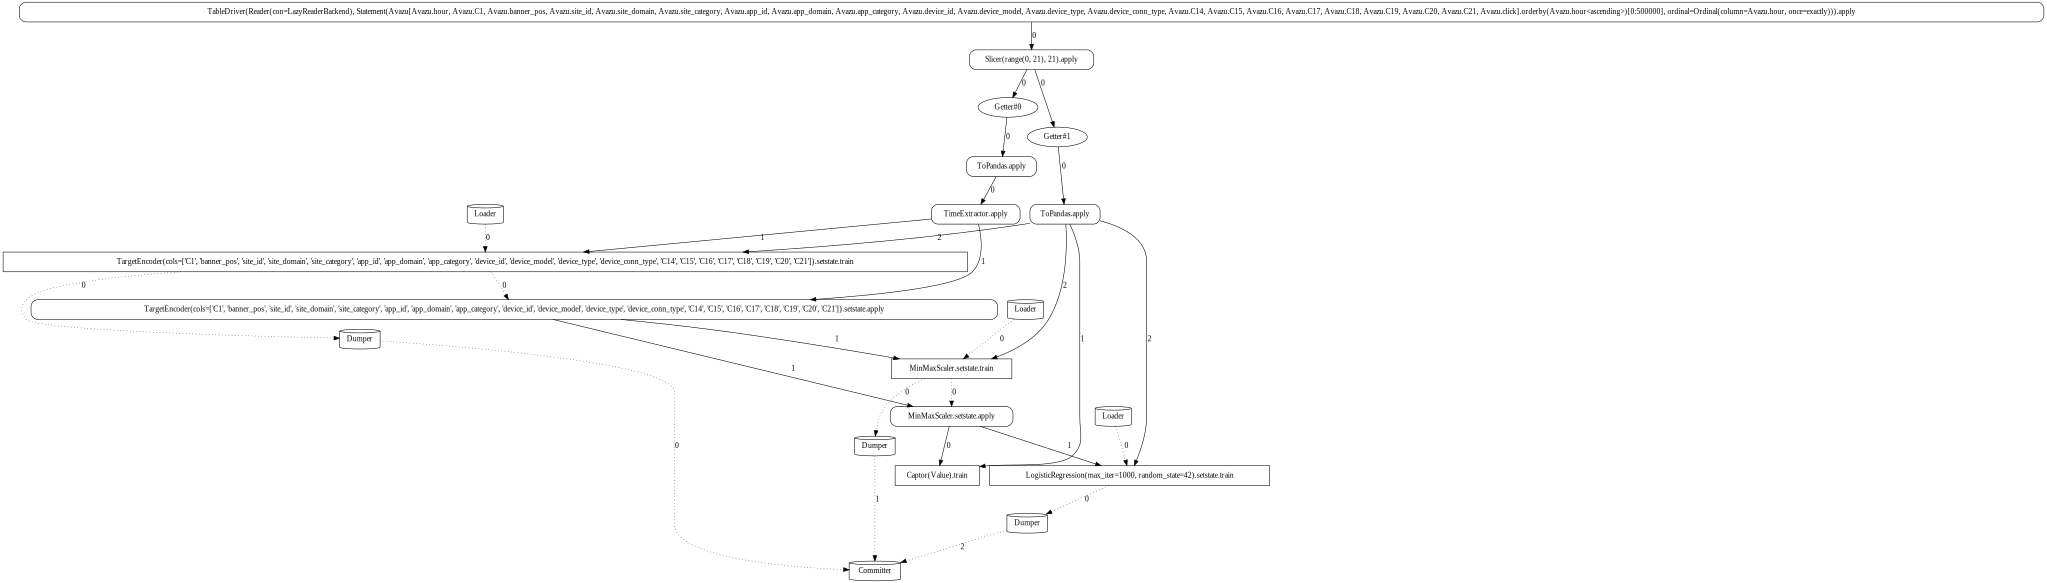

In [20]:
with wrap.importer():
    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import MinMaxScaler

PIPELINE = TimeExtractor() >> TargetEncoder(cols=CATEGORICAL_COLUMNS) >> MinMaxScaler() >> LogisticRegression(max_iter=1000, random_state=42)
SOURCE.bind(PIPELINE).launcher(runner='graphviz').train()

### Evaluating the Pipeline

Let's use our evaluation definition from [avazuctr/evaluation.py](forml-solution-avazuctr/avazuctr/evaluation.py) to get the `logloss` of our base model:

In [21]:
SOURCE.bind(PIPELINE, evaluation=PROJECT.components.evaluation).launcher.eval()

0.40116148032152915